In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from abc import ABC, abstractmethod

In [ ]:
class MAB(ABC):
    def __init__(self, k):
        self.k = k
        
    
    @abstractmethod
    def step(self, act):
        
        
    @abstractmethod
    def run(self, env):
        
        
    @abstractmethod
    def reset(self, env):
        
        

In [2]:
class eGreedyMAB(object):
    def __init__(self, k, eps):
        self.k = k
        self.eps = eps
        self.k_reward = np.zeros(self.k)
        self.reward = 0
        self.n = 0
        self.k_n = np.zeros(self.k)
        
        self.mu = np.random.normal(0,1, self.k)
    
    def step(self):
        p = np.random.rand()
        if p < self.eps:
            a = np.random.choice(self.k)
        else:
            a = np.argmax(self.k_reward)
            
        reward = np.random.normal(self.mu[a], 1)
        
        self.n += 1
        self.k_n += 1
        
        self.reward = self.reward + (reward - self.reward)/self.n
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a])/self.k_n[a]
    
    def reset(self, env):
        self.n = 0
        self.k_n = np.zeros(self.k)
        self.reward = 0
        self.k_reward = np.zeros(self.k)
        
    def run(self, iters):
        rewards = np.zeros(iters)
        for i in range(iters):
            self.step()
            rewards[i] = self.reward
        return rewards
        

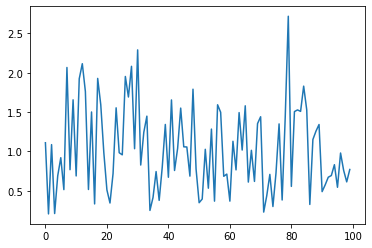

In [4]:
k = 10
iters = 1000
rewards = np.zeros(100)
eps = 0.1
for i in range(100):
    mab = eGreedyMAB(k, eps)
    rewards[i] = mab.run(iters)[-1]
    
plt.plot(rewards)